##### Importando as bibliotecas e Preparando os dados


In [1]:
# Importando as bibliotecas
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os
import seaborn as sns

# Bibliotecas para o modelo de rede neural convolucional
import tensorflow as tf

# Bibliotecas para avaliação do modelo
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

tf.get_logger().setLevel('ERROR')


In [2]:
# Declarando variáveis

# Caminho dos datasets
path = './chest_xray/'
normal_classe = 'NORMAL'
class_names = ['NORMAL', 'PNEUMONIA']

# Treino
treinamento_folder = os.path.join(path, 'train/')
treinamento_normal_dir = os.path.join(treinamento_folder, class_names[0])
treinamento_pneumonia_dir = os.path.join(treinamento_folder, class_names[1])

# Teste
teste_folder = os.path.join(path, 'test/')
teste_normal_dir = os.path.join(teste_folder, class_names[0])
teste_pneumonia_dir = os.path.join(teste_folder, class_names[1])

# Tamanho das imagens
img_width = 196
img_height = 196

# Variáveis para o treinamento
batch_size = 32
epochs = 100
learning_rate = 0.0001
patience = 15


In [3]:
# Carregando os datasets

# Carregando o dataset de treinamento
dataset_treinamento = tf.keras.preprocessing.image_dataset_from_directory(
    treinamento_folder,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

# Carregando o dataset de teste
dataset_teste_original = tf.keras.preprocessing.image_dataset_from_directory(
    teste_folder,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

dataset_test_cardinality = tf.data.experimental.cardinality(
    dataset_teste_original)

# Dividindo o dataset de teste em validação e teste onde 50% é para validação e 50% para teste
dataset_test_bathes = dataset_test_cardinality // 4

dataset_teste = dataset_teste_original.take(dataset_test_bathes)
dataset_validacao = dataset_teste_original.skip(dataset_test_bathes)


Found 5206 files belonging to 2 classes.
Found 666 files belonging to 2 classes.


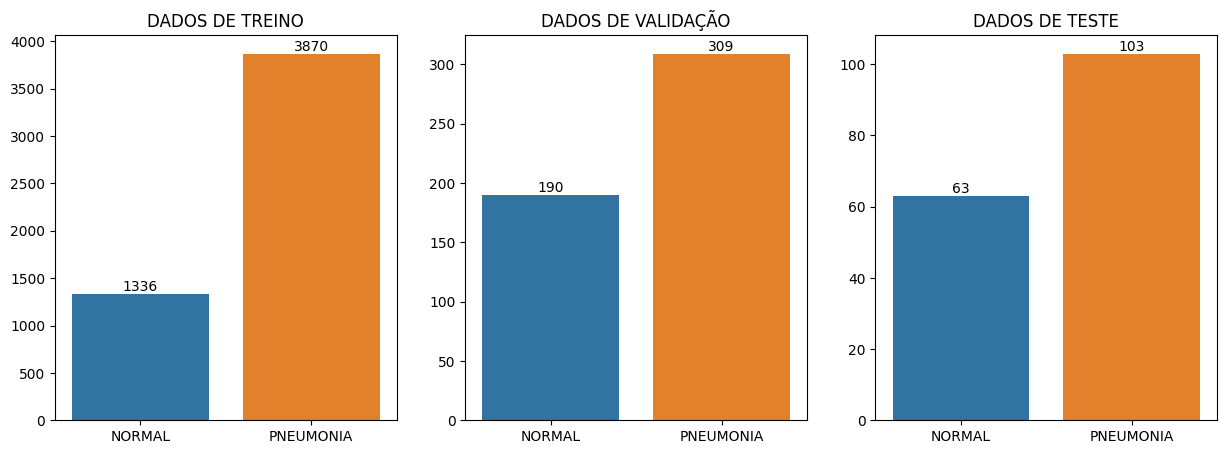

In [20]:
# Plotando graficos de barras com a quantidade de imagens de cada classe nos datasets
plt.figure(figsize=(15, 5))


def plot_quantidade(len_normal, len_pneumonia, title='', i=1):
    plt.subplot(1, 3, i)
    sns.barplot(x=class_names, y=[len_normal, len_pneumonia])
    plt.title(title)

    plt.text(0, len_normal, len_normal, ha='center', va='bottom')
    plt.text(1, len_pneumonia, len_pneumonia, ha='center', va='bottom')


plot_quantidade(len(os.listdir(treinamento_normal_dir)), len(
    os.listdir(treinamento_pneumonia_dir)), 'DADOS DE TREINO', 1)

validacao_quantidade_normal = int(len(os.listdir(teste_normal_dir)) * 0.75)
validacao_quantidade_pneumonia = int(
    len(os.listdir(teste_pneumonia_dir)) * 0.75)

teste_quantidade_normal = int(len(os.listdir(teste_normal_dir)) * 0.25)
teste_quantidade_pneumonia = int(len(os.listdir(teste_pneumonia_dir)) * 0.25)

plot_quantidade(validacao_quantidade_normal,
                validacao_quantidade_pneumonia, 'DADOS DE VALIDAÇÃO', 2)
plot_quantidade(teste_quantidade_normal,
                teste_quantidade_pneumonia, 'DADOS DE TESTE', 3)


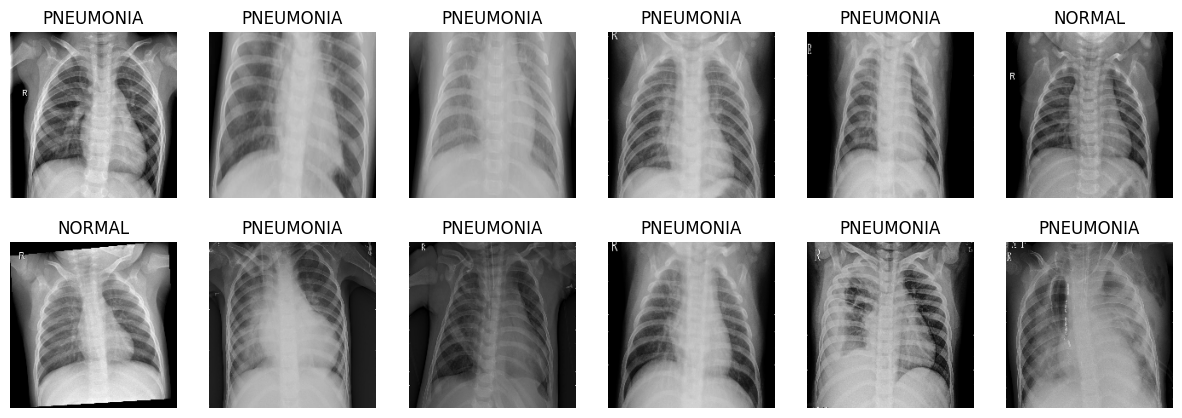

In [5]:
# Plotar imagens do dataset de treinamento
plt.figure(figsize=(15, 5))
for images, labels in dataset_treinamento.take(1):
    for i in range(12):
        ax = plt.subplot(2, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")


##### Criação e treinamento do modelo


In [6]:
# Modelagem COM Transferência de Aprendizado
# Aqui vamos preparar o modelo de acordo com nossos requisitos

# Vamos preparar nossa camada de entrada para passar o tamanho da imagem. o padrão é (224,224,3).
# Vamos alterá-lo para o tamanho da imagem que estamos usando.
input_layer = tf.keras.Input(shape=(img_width, img_height, 3))

# Inicializando o modelo de transferência  com as propriedades apropriadas para nossas necessidades.
# Estamos passando parâmetros como:
# 1) weights='imagenet' - Usando isso, estamos carregando os pesos como os pesos originais.
# 2) input_tensor para passar o modelo usando a camada de entrada que criamos.
# 3) Queremos alterar a última camada, então não estamos incluindo a camada superior

model_tl = tf.keras.applications.MobileNetV3Small(
    weights='imagenet', input_tensor=input_layer, include_top=False)


In [7]:
# Acessando a última camada do modelo e adicionando Flatten e Dense após ela

# Separando a última camada do modelo
last_layer = model_tl.output

# Adicionando uma camada Flatten
flatten = tf.keras.layers.Flatten()(last_layer)

# Adicionando uma camada Dense para a camada de saída final
output_layer = tf.keras.layers.Dense(2, activation='softmax')(flatten)

# Criando o modelo com a camada de entrada e a camada de saída
modelMVNET = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

# Congelando todas as camadas, exceto a última camada para impedir que o modelo de transferência do conhecimento seja treinado novamente
for layer in modelMVNET.layers[:-1]:
    layer.trainable = False
    
# Sumário do modelo final com as camadas adicionadas
modelMVNET.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 196, 196, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 196, 196, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 98, 98, 16)   432         ['rescaling[0][0]']              
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 98, 98, 16)  64          ['Conv[0][0]']               

In [8]:
# # Congelando todas as camadas, exceto a última camada para impedir que o modelo de transferência do conhecimento seja treinado novamente

# for layer in model.layers[:-1]:
#     layer.trainable = False

# # model.summary()

# # Congelando todas as camadas, exceto a última camada para impedir que o modelo de transferência do conhecimento seja treinado novamente
# for layer in modelMVNET.layers[:-1]:
#     layer.trainable = False


In [9]:
# Data Augmentation

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.3),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.05),
])

# Aplicando data augmentation no modelo

model = tf.keras.Sequential([
    data_augmentation,
    modelMVNET
])


<Figure size 640x480 with 0 Axes>

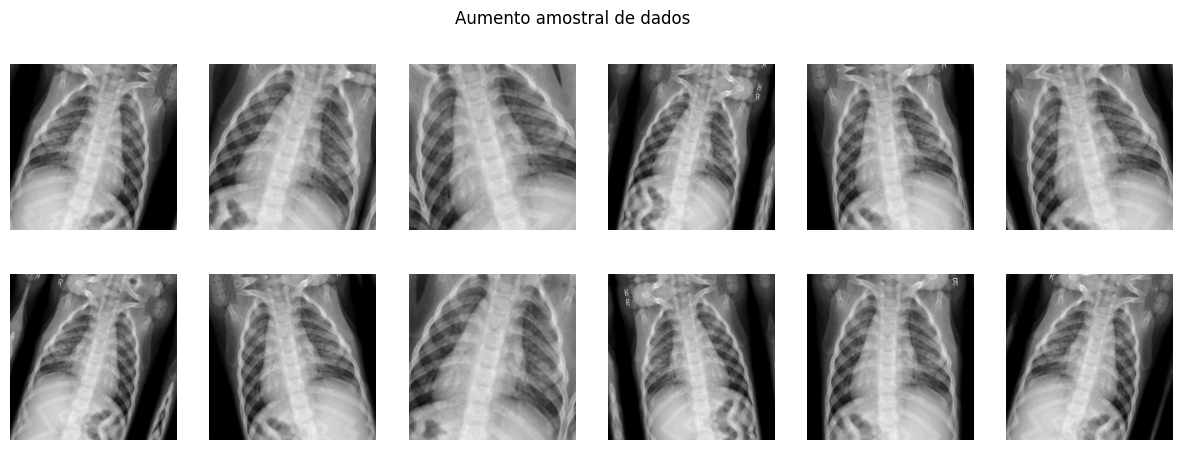

In [10]:
# Plotando imagens com Data Augmentation

def plot_dataset_data_augmentation(dataset):
    plt.gcf().clear()
    plt.figure(figsize=(15, 5))

    for features, _ in dataset.take(1):
        feature = features[0]

        plt.suptitle('Aumento amostral de dados')

        for i in range(12):
            feature_data_augmentation = data_augmentation(
                feature, training=True)

            plt.subplot(2, 6, i + 1)
            plt.axis('off')

            plt.imshow(feature_data_augmentation.numpy().astype('uint8'))


plot_dataset_data_augmentation(dataset_treinamento)


In [11]:
# Compilando o modelo e definindo o otimizador e a função de perda

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(
        learning_rate=learning_rate
    ),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)


In [12]:
# Treinamento do modelo

# Monitora a perda de validação e interrompe o treinamento quando a perda
# de validação não melhora por muitas épocas consecutivas para evitar overfitting
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=patience,
    restore_best_weights=True,
    mode='min',
    verbose=1
)

history = model.fit(
    dataset_treinamento,
    epochs=epochs,
    batch_size=batch_size,
    verbose=True,
    validation_data=dataset_validacao,
    callbacks=[earlystopping],
)

loss, accuracy = model.evaluate(dataset_teste)

print('Loss: {:.2f}'.format(loss))
print('Accuracy: {:.2f}'.format(accuracy))


Epoch 1/100
163/163 [==============================] - 80s 419ms/step - loss: 0.2737 - accuracy: 0.8988 - val_loss: 0.9631 - val_accuracy: 0.7332
Epoch 2/100
163/163 [==============================] - 68s 410ms/step - loss: 0.1247 - accuracy: 0.9531 - val_loss: 0.3763 - val_accuracy: 0.8814
Epoch 3/100
163/163 [==============================] - 68s 410ms/step - loss: 0.1063 - accuracy: 0.9618 - val_loss: 0.9115 - val_accuracy: 0.7747
Epoch 4/100
163/163 [==============================] - 69s 419ms/step - loss: 0.1017 - accuracy: 0.9650 - val_loss: 0.2982 - val_accuracy: 0.9032
Epoch 5/100
163/163 [==============================] - 67s 405ms/step - loss: 0.0853 - accuracy: 0.9718 - val_loss: 1.3129 - val_accuracy: 0.7253
Epoch 6/100
163/163 [==============================] - 67s 404ms/step - loss: 0.0706 - accuracy: 0.9748 - val_loss: 0.6719 - val_accuracy: 0.8300
Epoch 7/100
163/163 [==============================] - 68s 412ms/step - loss: 0.0676 - accuracy: 0.9748 - val_loss: 0.3636 -

<Figure size 640x480 with 0 Axes>

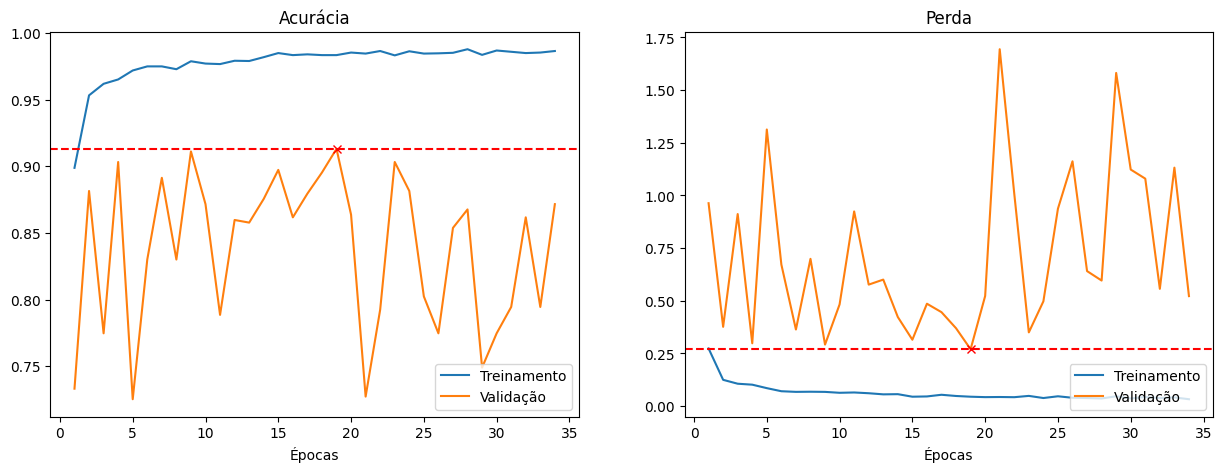

In [13]:
# Função para plotar gráficos de acurácia e loss do modelo
def plot_model(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(accuracy) + 1)

    plt.gcf().clear()
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.title('Acurácia')
    plt.plot(epochs_range, accuracy, label='Treinamento')
    plt.plot(epochs_range, val_accuracy, label='Validação')
    plt.legend(loc='lower right')

    plt.plot(np.argmax(val_accuracy)+1, np.max(val_accuracy),
             marker='x', color='r', label='Melhor acurácia')
    plt.axhline(y=np.max(val_accuracy), color='r', linestyle='--')

    plt.xlabel('Épocas')

    plt.subplot(1, 2, 2)
    plt.title('Perda')
    plt.plot(epochs_range, loss, label='Treinamento')
    plt.plot(epochs_range, val_loss, label='Validação')
    plt.legend(loc='lower right')

    plt.plot(np.argmin(val_loss)+1, np.min(val_loss),
             marker='x', color='r', label='Melhor perda')
    plt.axhline(y=np.min(val_loss), color='r', linestyle='--')

    plt.xlabel('Épocas')


plot_model(history)


##### Validação do modelo


In [51]:
# Função para plotar imagens e predições do modelo
def plot_results(dataset):

    features, labels = dataset.as_numpy_iterator().next()
    predictions = model.predict(features)

    num_rows = 4
    num_cols = 4
    total = num_rows*num_cols

    plt.gcf().clear()
    plt.figure(figsize=(2*num_cols, 2*num_rows))

    len = predictions.shape[0]

    arrayindex = random.sample(range(len), 25)

    for i in range(total):
        plt.subplot(num_rows, num_cols, i+1)
        index = arrayindex[i]

        predictions_array = predictions[index]
        true_label = np.argmax(labels, axis=1)[index]

        plt.grid(False)
        plt.xticks([])
        plt.yticks([])

        plt.imshow(features[index].astype('uint8'), cmap=plt.cm.binary)

        predicted_label = np.argmax(predictions_array)

        if (predicted_label == true_label):
            color = 'green'
        else:
            color = 'red'

        percentage = 100*np.max(predictions_array)

        plt.xlabel("{} {:2.0f}% \n ({})".format(
            class_names[predicted_label], percentage, class_names[true_label]), color=color)

    plt.subplots_adjust(hspace=0.5)


1/1 [==============================] - 0s 59ms/step


<Figure size 640x480 with 0 Axes>

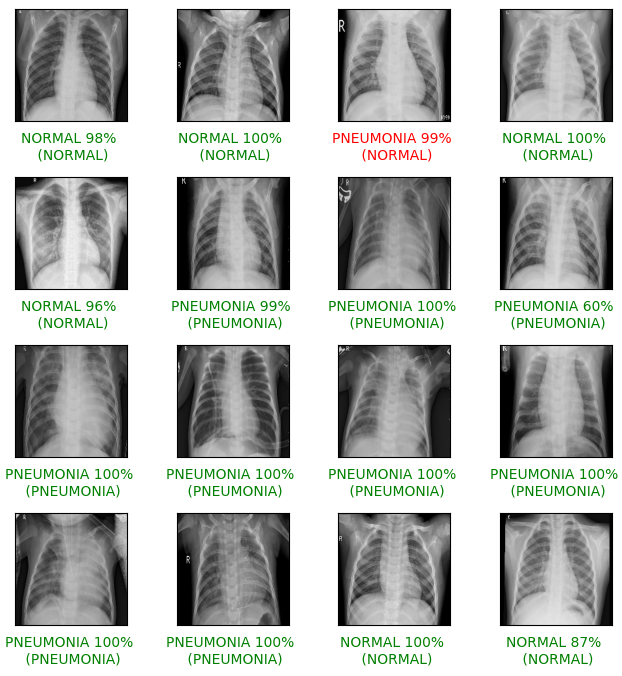

In [61]:
# Plotando os resultados do modelo no dataset de validacao
plot_results(dataset_validacao)


1/1 [==============================] - 0s 38ms/step


<Figure size 640x480 with 0 Axes>

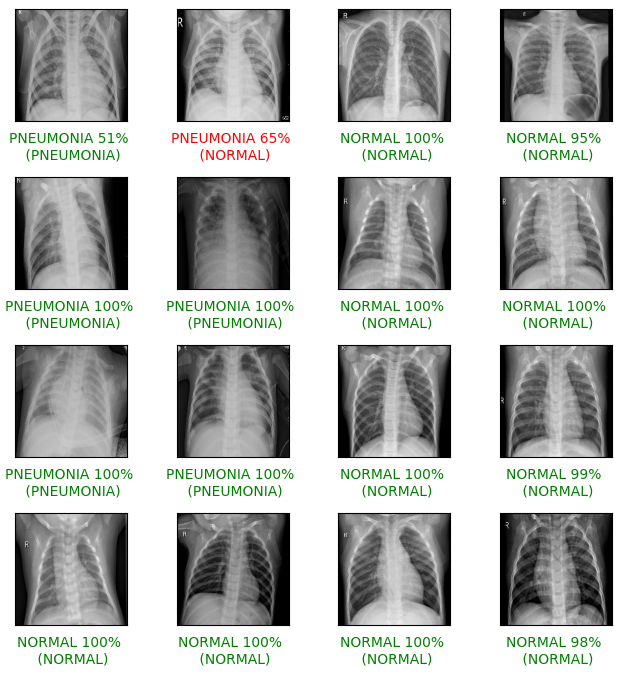

In [57]:
# Plotando os resultados do modelo no dataset de teste
plot_results(dataset_teste)


In [17]:
# Função para obter os resultados do modelo

def get_results(dataset):
    count = 0
    label_list = []
    prediction_list = []
    features_list = []

    for features, labels in dataset:
        predictions = model.predict(features)
        for i in range(batch_size):
            label = np.argmax(labels[i])
            label_list.append(label)
            features_list.append(features[i])

            prediction_list.append(np.argmax(predictions[i]))
            count += 1

            if (i+1 == len(predictions)):
                break

    return features_list, label_list, prediction_list


val_features, val_labels, val_predictions = get_results(dataset_validacao)
test_features, test_labels, test_predictions = get_results(dataset_teste)


1/1 [==============================] - 0s 62ms/step


Porcentagem de acerto - Validação: 92%
Porcentagem de acerto - Teste: 92%


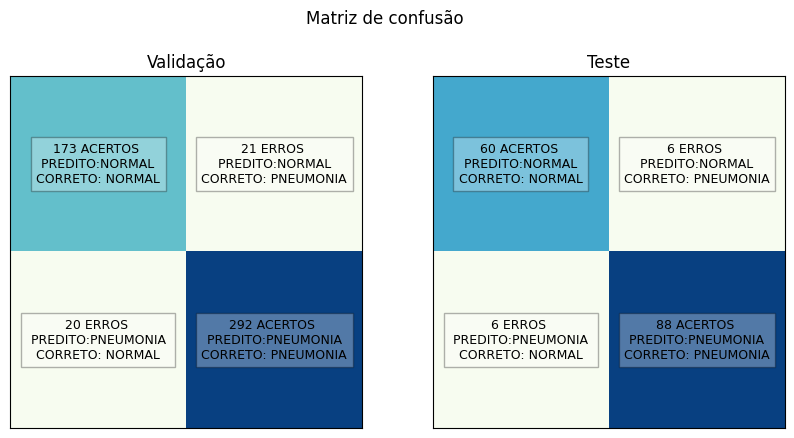

In [93]:
# Matriz de confusão

plt.figure(figsize=(10, 5))
plt.suptitle("Matriz de confusão")


def plot_confusion_matrix(predictions, labels, title='Confusion Matrix', i=1):
    plt.subplot(1, 2, i)
    
    # Matriz de confusão
    matrix = confusion_matrix(labels, predictions)

    porcentagem_acerto = (matrix[0, 0] + matrix[1, 1]) / np.sum(matrix) * 100

    print(f'Porcentagem de acerto - {title}: {round(porcentagem_acerto)}%')

    plt.imshow(matrix, cmap=plt.cm.GnBu)

    # Adicionando os nomes das classes e os valores
    for i in range(2):
        for j in range(2):
            text = 'ACERTO' if i == j else 'ERRO'
            
            class_predict = class_names[i] if i == j else class_names[j]
            
            text_final = f'{matrix[i, j]} {text}S \n PREDITO:{class_predict} \nCORRETO: {class_names[i]}'
            plt.text(i, j, text_final, va='center', ha='center', color='black', bbox=dict(facecolor='white', alpha=0.3), fontsize=9)
        
    plt.title(title)
    
    plt.tick_params(left=False, right=False, labelleft=False,
                    labelbottom=False, bottom=False)


plot_confusion_matrix(val_labels, val_predictions,
                      title='Validação', i=1)
plot_confusion_matrix(test_labels, test_predictions,
                      title='Teste', i=2)


(0.9226305609284333, 0.9226305609284333, 0.9226305609284333, None)

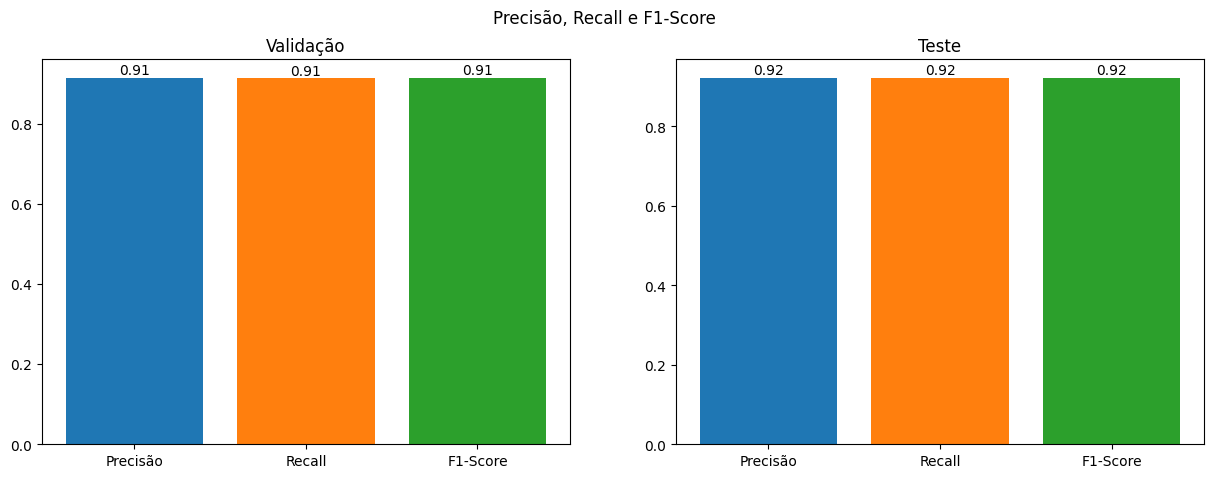

In [19]:
# Gráfico de precisão, recall e f1-score

plt.figure(figsize=(15, 5))
plt.suptitle("Precisão, Recall e F1-Score")


def plot_precision(predictions, labels, title='Precisão', i=1):
    precision = precision_recall_fscore_support(
        labels, predictions, average='macro')

    plt.subplot(1, 2, i)
    plt.bar(['Precisão'], precision[0])
    plt.bar(['Recall'], precision[1])
    plt.bar(['F1-Score'], precision[2])

    # Exibindo os valores de precisão, recall e f1-score
    plt.text(0, precision[0], round(precision[0], 2), ha='center', va='bottom')
    plt.text(1, precision[1], round(precision[1], 2), ha='center', va='bottom')
    plt.text(2, precision[2], round(precision[2], 2), ha='center', va='bottom')
    plt.title(title)
    return precision


plot_precision(val_predictions, val_labels,
               title='Validação', i=1)
plot_precision(test_predictions, test_labels,
               title='Teste', i=2)
